In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import random

# dataset, dataloader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 64

def aff(e):
  return e * 2 - 1

transform = transforms.Compose(
  [
    transforms.ToTensor(),
    aff,
    transforms.RandomHorizontalFlip(p=0.5)
  ]
)

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Files already downloaded and verified


# utils

In [4]:
def img_show(img):
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.permute(1,2,0)/2+0.5)

In [5]:
def gen_fake_inputs(batch):
  return Variable(torch.randn(batch, z_dim).to(device))

def gen_labels(batch, value):
  return Variable((torch.zeros(batch, 1) + value).to(device))

In [40]:
def write_to_log(msg):
  with open('cifar_log.txt', 'a') as f:
    f.write(msg + '\n')

# network

In [175]:
class Generator(nn.Module):
  def __init__(self, g_input_dim):
    super(Generator, self).__init__()
    self.fc = nn.Linear(g_input_dim, 4096)
    
    self.up1 = self._gen_seq(256, 128)
    self.up2 = self._gen_seq(128, 128)
    self.up3 = self._gen_seq(128, 64)
    self.fin_conv = nn.Conv2d(64, 3, 3, padding=1)
  
  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.Upsample(scale_factor=2),
      nn.LeakyReLU(0.2)
    )

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc(x))
    x = x.reshape(-1, 256, 4, 4)
    x = self.up1(x)
    x = self.up2(x)
    x = self.up3(x)
    return torch.tanh(self.fin_conv(x))

class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()
		self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
		self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
		self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
		self.bn1 = nn.BatchNorm2d(128)
		self.bn2 = nn.BatchNorm2d(256)
		self.fc1 = nn.Linear(4*4*256, 1)

	def forward(self, x):
		x = self.conv1(x)
		x = F.leaky_relu(x)

		x = self.conv2(x)
		x = self.bn1(x)
		x = F.leaky_relu(x)

		x = self.conv3(x)
		x = self.bn2(x)
		x = F.leaky_relu(x)

		x = x.view(-1, 4*4*256)
		x = self.fc1(x)
		x = torch.sigmoid(x)
		return x

# build network

In [176]:
z_dim = 100

G = Generator(g_input_dim = z_dim).to(device)
D = Discriminator().to(device)

In [177]:
# loss
criterion = nn.BCELoss()

# optimizer
g_lr = 0.0002
d_lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = g_lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = d_lr)

In [178]:
def D_train(x):
  #=======================Train the discriminator=======================#
  D.zero_grad()

  # train discriminator on real
  _bs = x.shape[0]
  x_real, y_real = Variable(x.to(device)), gen_labels(_bs, 1)

  D_output = D(x_real)
  D_real_loss = criterion(D_output, y_real)

  # train discriminator on fake
  z = gen_fake_inputs(_bs)
  x_fake, y_fake = G(z), gen_labels(_bs, 0)

  D_output = D(x_fake)
  D_fake_loss = criterion(D_output, y_fake)

  # gradient backprop & optimize ONLY D's parameters
  D_loss = D_real_loss + D_fake_loss
  D_loss.backward()
  D_optimizer.step()
      
  return  D_loss.data.item()

def G_train():
  #=======================Train the generator=======================#
  G.zero_grad()

  z = gen_fake_inputs(bs)
  y = gen_labels(bs, 1)

  G_output = G(z)
  D_output = D(G_output)
  G_loss = criterion(D_output, y)

  # gradient backprop & optimize ONLY G's parameters
  G_loss.backward()
  G_optimizer.step()
      
  return G_loss.data.item()

In [179]:
fake_len = 12
fake_inputs = gen_fake_inputs(fake_len)
fake_inputs = gen_fake_inputs(fake_len)

def gen_fake_img():
  plt.figure(figsize=(5, 1.6))
  b = G(fake_inputs)
  for i in range(0, fake_len):
    b_n = b[i].cpu().detach()
    plt.subplot(2, int(fake_len / 2), i+1)
    img_show(b_n)
  plt.show()

In [180]:
def test_fake_efficiency(is_round = False):
  e = 10
  s = 0
  for i in range(e):
    a = gen_fake_inputs(bs)
    b = G(a)
    D_output = D(b)
    if is_round:
      D_output = torch.round(D_output)
    D_true = torch.sum(D_output).item() / bs
    s += D_true
  return s / e

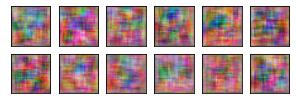

In [181]:
gen_fake_img()

In [182]:
test_fake_efficiency()

0.573933583498001

In [ ]:
n_epoch = 200
d_error_rate = 1


for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  for batch_idx, (x, _) in enumerate(train_loader):

    if batch_idx % 10 == 0:
      print('|', end='')
    
    # d_error_rate = test_fake_efficiency()

    # if d_error_rate > random.normalvariate(0.5, 0.1):
    #   D_losses.append(D_train(x))
    # else:
    #   G_losses.append(G_train())

    D_losses.append(D_train(x))
    G_losses.append(G_train())

    # if batch_idx % 150 == 0:
    #   print('%.3f ' % d_error_rate)
    #   gen_fake_img()
  

  ld = 0
  lg = 0
  if len(D_losses) > 0:
    ld = torch.mean(torch.FloatTensor(D_losses))
  if len(G_losses) > 0:
    lg = torch.mean(torch.FloatTensor(G_losses))

  print()
  d_error_rate = test_fake_efficiency()
  d_error_rate_round = test_fake_efficiency(True)
  msg = '[%d/%d]: loss_d: %.3f, loss_g: %.3f, d_error: %.6f, d_error_round: %.3f' % (
    (epoch), n_epoch, ld, lg, d_error_rate, d_error_rate_round)
  write_to_log(msg)
  print(msg)

  torch.save(G.state_dict(), 'cifar_generator_1.pth')
  torch.save(D.state_dict(), 'cifar_discriminator_1.pth')
  
  gen_fake_img()

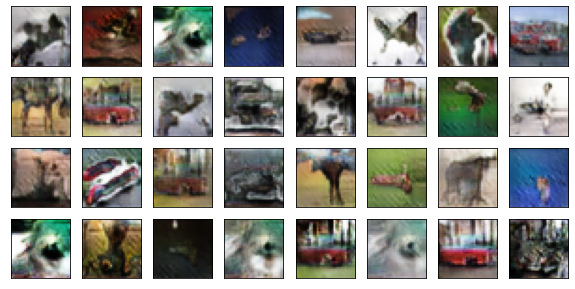

In [187]:
fake_len = 32
fake_inputs = gen_fake_inputs(fake_len)

def gen_fake_img():
  plt.figure(figsize=(10, 5))
  b = G(fake_inputs)
  for i in range(0, fake_len):
    b_n = b[i].cpu().detach()
    plt.subplot(4, int(fake_len / 4), i+1)
    img_show(b_n)
  plt.show()

gen_fake_img()